In [47]:
import os
import pandas as pd
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import argparse
import copy
import datetime
import matplotlib.pyplot as plt
import pickle

In [48]:
run_config = dict(
    features_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', \
        'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'ESO TEL AMBI RHUM', \
            'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', 'HIERARCH ESO TEL AMBI TEMP', \
                'ESO DET NDIT', 'ESO DET SEQ1 DIT', 'SIMBAD_FLUX_G', 'SIMBAD_FLUX_H', 'SEEING_MEDIAN', \
                    'SEEING_STD', 'COHERENCE_TIME_MEDIAN', 'COHERENCE_TIME_STD', 'SCFOVROT', 'SEPARATION', 'NSIGMA_CONTRAST'],
    categorical_features = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE'],
    random_state = 42,
    separation_size = 124
)

In [49]:
# Define the model
class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features, num_hidden_layers):
        layers = []
        layers.append(nn.Linear(input_features, hidden_features))
        layers.append(nn.ReLU())
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_features, output_features))
        
        super().__init__(*layers)

criterion = nn.MSELoss()

In [50]:
# Define the model
class MLP_uncertainty(nn.Module):
    # This MLP will predict the mean and variance in order to calculate the uncertainty
    def __init__(self, input_features, hidden_features, num_hidden_layers):
        super().__init__()
        self.input_features = input_features
        self.hidden_features = hidden_features
        self.num_hidden_layers = num_hidden_layers

        # Define the layers
        self.input_layer = nn.Linear(self.input_features, self.hidden_features)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.hidden_features, self.hidden_features) for _ in range(self.num_hidden_layers)])
        
        self.mean_layer = nn.Linear(self.hidden_features, 1)

        self.std_layer = nn.Linear(self.hidden_features, 1)

    def forward(self, x):
        # Forward pass
        x = nn.functional.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = nn.functional.relu(hidden_layer(x))

        mean = self.mean_layer(x)
        # Assume we have log variance as output
        log_std = self.std_layer(x)

        return mean, log_std    

In [51]:
def get_file_names(path):
    """"
    Returns a list of file names in a directory
    """
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

print(get_file_names("Meetings notes"))

['TODO.txt', '221027 (Julien).txt', '221118 (Olivier, Elodie, Gilles).txt']


In [52]:
def reshape_dataframe(df, vec_column_name_list):
    """
    Reshape a dataframe containing vectors in order to have one row per element of the vectors.
    The metadata of the row is repeated for each element of the vectors.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to reshape
    vec_column_name_list : list
        The list of the columns containing vectors

    Returns
    -------
    df_reshaped : pandas.DataFrame
        The reshaped dataframe
    """

    columns = df.columns
    reshape_dataframe = {}

    # Initialize the dictionary
    for column in columns:
        reshape_dataframe[column] = []

    # Fill the dictionary
    for index, row in df.iterrows():
        # Create a dictionnary with only the metadata of the row, that is without the columns in vec_column_name_list
        meta_dict = row.drop(vec_column_name_list).to_dict()

        # Check whether the dimensions of the vectors are the same
        for column in vec_column_name_list:
            if len(row[column]) != len(row[vec_column_name_list[0]]):
                raise ValueError("The dimensions of the vectors are not the same")

        for i in range(len(row[vec_column_name_list[0]])):
            # Add the metadata to the dictionary
            for key, value in meta_dict.items():
                reshape_dataframe[key].append(value)

            # Add the vector to the dictionary
            for column in vec_column_name_list:
                reshape_dataframe[column].append(row[column][i])

    # Create a dataframe from the dictionary
    df_reshaped = pd.DataFrame(reshape_dataframe)
    return df_reshaped

In [53]:
def make_data_vector(df_AD, config):

    # Check whether df_AD contains 'SEPARATION' and 'NSIGMA_CONTRAST'
    if 'SEPARATION' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'SEPARATION'")
    if 'NSIGMA_CONTRAST' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'NSIGMA_CONTRAST'")

    # The numerical features are the ones that are not categorical
    numerical_features = list(set(config.features_to_keep) - set(config.categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

    # Get a dataframe containing only the columns we want to keep
    df_AD = df_AD[config.features_to_keep]

    # Convert the strings to numbers in order to transform it into a tensor
    df_AD.loc[:, 'ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
    df_AD.loc[:, 'ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
    df_AD.loc[:, 'ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]

    # Get values of separation between 0 and 1
    separation = np.array(df_AD['SEPARATION'][0])
    separation = separation / np.max(separation)

    # Replace every separation vectors with the new one
    df_AD.loc[:, 'SEPARATION'] = df_AD['SEPARATION'].apply(lambda x: np.array(x) / np.max(x))

    # Split the data into train, validation and test sets
    train = df_AD.sample(frac=0.8, random_state=config.random_state)
    validation = df_AD.drop(train.index)
    test = validation.sample(frac=0.5, random_state=config.random_state)
    validation = validation.drop(test.index)

    # Transform the NaN values into the median of the column of the training set (only for the numerical features)
    imp = KNNImputer(n_neighbors=5, weights="uniform")
    train[numerical_features] = imp.fit_transform(train[numerical_features])
    test[numerical_features] = imp.transform(test[numerical_features])
    validation[numerical_features] = imp.transform(validation[numerical_features])

    # Split the data into features and labels
    x_train = train.drop(['NSIGMA_CONTRAST', 'SEPARATION'], axis=1) # Drop SEPARATION in order not to have a vector as input
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['NSIGMA_CONTRAST', 'SEPARATION'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

    x_validation = validation.drop(['NSIGMA_CONTRAST', 'SEPARATION'], axis=1)
    y_validation = validation['NSIGMA_CONTRAST']

    # Standardize the data
    scaler = StandardScaler()
    x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
    x_test[numerical_features] = scaler.transform(x_test[numerical_features])
    x_validation[numerical_features] = scaler.transform(x_validation[numerical_features])

    # Convert the dataframes to numpy arrays
    x_train = (x_train.values).astype(np.float32)
    y_train = np.array(y_train.tolist()).astype(np.float32)
    x_test = (x_test.values).astype(np.float32)
    y_test = np.array(y_test.tolist()).astype(np.float32)
    x_validation = (x_validation.values).astype(np.float32)
    y_validation = np.array(y_validation.tolist()).astype(np.float32)

    return x_train, np.log10(y_train), x_test, np.log10(y_test), x_validation, np.log10(y_validation)

In [54]:
def make_data_single(df_AD, config):

    # Check whether df_AD contains 'SEPARATION' and 'NSIGMA_CONTRAST'
    if 'SEPARATION' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'SEPARATION'")
    if 'NSIGMA_CONTRAST' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'NSIGMA_CONTRAST'")

    # The numerical features are the ones that are not categorical
    numerical_features = list(set(config.features_to_keep) - set(config.categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

    # Get a dataframe containing only the columns we want to keep
    df_AD = df_AD[config.features_to_keep]

    # Convert the strings to numbers in order to transform it into a tensor
    df_AD.loc[:, 'ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
    df_AD.loc[:, 'ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
    df_AD.loc[:, 'ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]

    # Get values of separation between 0 and 1
    separation = np.array(df_AD['SEPARATION'][0])
    separation = separation / np.max(separation)

    # Replace every separation vectors with the new one
    df_AD.loc[:, 'SEPARATION'] = df_AD['SEPARATION'].apply(lambda x: np.array(x) / np.max(x))

    # Split the data into train, validation and test sets
    train = df_AD.sample(frac=0.8, random_state=config.random_state)
    validation = df_AD.drop(train.index)
    test = validation.sample(frac=0.5, random_state=config.random_state)
    validation = validation.drop(test.index)

    # Transform the NaN values into the median of the column of the training set (only for the numerical features)
    imp = KNNImputer(n_neighbors=5, weights='uniform')
    train[numerical_features] = imp.fit_transform(train[numerical_features])
    test[numerical_features] = imp.transform(test[numerical_features])
    validation[numerical_features] = imp.transform(validation[numerical_features])

    # Reshape the dataframes (note that the reshape is done after the train/test split to avoid data leakage)
    train = reshape_dataframe(train, ['SEPARATION', 'NSIGMA_CONTRAST'])
    test = reshape_dataframe(test, ['SEPARATION', 'NSIGMA_CONTRAST'])
    validation = reshape_dataframe(validation, ['SEPARATION', 'NSIGMA_CONTRAST'])

    # Split the data into features and labels
    x_train = train.drop(['NSIGMA_CONTRAST'], axis=1)
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['NSIGMA_CONTRAST'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

    x_validation = validation.drop(['NSIGMA_CONTRAST'], axis=1)
    y_validation = validation['NSIGMA_CONTRAST']

    # Standardize the data
    scaler = StandardScaler()
    x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
    x_test[numerical_features] = scaler.transform(x_test[numerical_features])
    x_validation[numerical_features] = scaler.transform(x_validation[numerical_features])

    # Convert the dataframes to numpy arrays
    x_train = (x_train.values).astype(np.float32)
    y_train = np.array(y_train.tolist()).astype(np.float32)
    x_test = (x_test.values).astype(np.float32)
    y_test = np.array(y_test.tolist()).astype(np.float32)
    x_validation = (x_validation.values).astype(np.float32)
    y_validation = np.array(y_validation.tolist()).astype(np.float32)

    return x_train, np.log10(y_train), x_test, np.log10(y_test), x_validation, np.log10(y_validation)

In [55]:
df_AD = pd.read_pickle('Dataset_creation/df_AD_timestamps.pkl')
# Print the shape of the dataframe
print(df_AD.shape)
# Print the columns of the dataframe
print(df_AD.columns)
x_train_single, y_train_single, x_test_single, y_test_single, x_validation_single, y_validation_single = make_data_single(df_AD, argparse.Namespace(**run_config))
x_train_vector, y_train_vector, x_test_vector, y_test_vector, x_validation_vector, y_validation_vector = make_data_vector(df_AD, argparse.Namespace(**run_config))

# Convert to tensors 
x_train_single_tensor = torch.tensor(x_train_single, dtype=torch.float32)
y_train_single_tensor = torch.tensor(y_train_single, dtype=torch.float32)
x_test_single_tensor = torch.tensor(x_test_single, dtype=torch.float32)
y_test_single_tensor = torch.tensor(y_test_single, dtype=torch.float32)
x_validation_single_tensor = torch.tensor(x_validation_single, dtype=torch.float32)
y_validation_single_tensor = torch.tensor(y_validation_single, dtype=torch.float32)

x_train_vector_tensor = torch.tensor(x_train_vector, dtype=torch.float32)
y_train_vector_tensor = torch.tensor(y_train_vector, dtype=torch.float32)
x_test_vector_tensor = torch.tensor(x_test_vector, dtype=torch.float32)
y_test_vector_tensor = torch.tensor(y_test_vector, dtype=torch.float32)
x_validation_vector_tensor = torch.tensor(x_validation_vector, dtype=torch.float32)
y_validation_vector_tensor = torch.tensor(y_validation_vector, dtype=torch.float32)

(843, 33)
Index(['folder', 'ESO OBS ID', 'DATE-OBS', 'OBJECT', 'ESO TEL AIRM MEAN',
       'EFF_NFRA', 'EFF_ETIM', 'SR_AVG', 'ESO INS4 FILT3 NAME',
       'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP',
       'SCFOVROT', 'SC MODE', 'ESO TEL AMBI RHUM',
       'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP',
       'HIERARCH ESO TEL AMBI TEMP', 'OBS_STA', 'OBS_END', 'ESO DET NDIT',
       'ESO DET SEQ1 DIT', 'OBS_STA_TIMESTAMPS', 'OBS_END_TIMESTAMPS',
       'TIMESTAMPS_DIR', 'SEPARATION', 'NSIGMA_CONTRAST', 'SIMBAD_FLUX_G',
       'SIMBAD_FLUX_H', 'SEEING_MEDIAN', 'SEEING_STD', 'COHERENCE_TIME_MEDIAN',
       'COHERENCE_TIME_STD'],
      dtype='object')


Model 1 : Neural network (single) with 15 hidden layers and 512 hidden units
Validation loss for model 1: 0.3602084219455719
Model 2 : Neural network (single) with 20 hidden layers and 512 hidden units
Validation loss for model 2: 0.3743242025375366
Model 3 : Neural network (single) with 10 hidden layers and 512 hidden units
Validation loss for model 3: 0.3789876699447632
Model 4 : Neural network (single) with 5 hidden layers and 512 hidden units
Validation loss for model 4: 0.4336964190006256
Model 5 : Neural network (single) with 20 hidden layers and 512 hidden units
Validation loss for model 5: 0.4366541802883148
Model 6 : Neural network (single) with 20 hidden layers and 512 hidden units
Validation loss for model 6: 0.3111058175563812


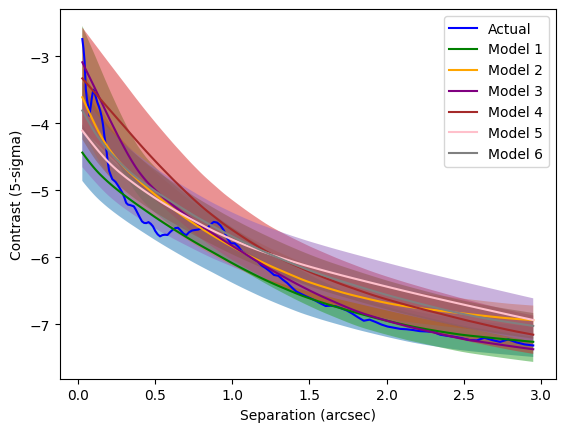

In [56]:
obs_id = 67

path = 'TO_PLOT/'
# Get the model names
model_names = get_file_names(path)
# Remove the files that are not models (the files that do not end with .pth or .pkl)
model_names = [name for name in model_names if name.endswith('.pth') or name.endswith('.pkl')]

separation = np.array(df_AD['SEPARATION'][obs_id])
contrast = y_test_vector[obs_id]

plt.plot(separation, contrast, color='blue', label='Actual')

color_list = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black']

model_id = 1

# Load the models
for name in model_names:
    val_loss = 0
    # Neural networks
    if name.startswith('MLP'):
        # Retrieve the input size 
        input_size = int(name.split('_input_size_')[1].split('_')[0])
        # Retrieve the number of hidden layers
        hidden_layers = int(name.split('_n_hidden_layers_')[1].split('_')[0])
        # Retrieve the number of hidden units
        hidden_units = int(name.split('_hidden_size_')[1].split('_')[0])
        # Retrieve the output size
        if name.split('_')[1] == 'single':
            # Uncertainty or contrast ?
            if name.split('_')[2] == 'uncertainty':
                output_size = 2
            elif name.split('_')[2] == 'nsigma':
                output_size = 1
            else :
                raise ValueError('Unknown output size')
        elif name.split('_')[1] == 'vector':
            output_size = 124
        else:
            raise ValueError('Unknown output size')

        # Create the model
        if name.split('_')[2] == 'uncertainty':
            model = MLP_uncertainty(input_size, hidden_units, hidden_layers)
        elif name.split('_')[2] == 'nsigma': 
            model = MLP(input_size, output_size, hidden_units, hidden_layers)
        else:
            raise ValueError('Unknown output size')

        # load the state dict
        model.load_state_dict(torch.load(path + name))

        # Try and see if the model is well trained on the validation set and plot the predictions on the test set
        model.eval()
        with torch.no_grad():
            if output_size == 1:
                # Validation to be sure that the model is well trained
                outputs = model(x_validation_single_tensor)
                val_loss = criterion(outputs, y_validation_single_tensor.view(-1, 1)).item()
                # Plot the predictions
                start = obs_id * len(separation)
                stop = start + len(separation)
                outputs = model(x_test_single_tensor[start:stop])
                plt.plot(separation, outputs, color=color_list[model_id], label="Model {}".format(model_id))
                print("Model {} : Neural network (single) with {} hidden layers and {} hidden units".format(model_id, hidden_layers, hidden_units))
            elif output_size == 2:
                # Validation to be sure that the model is well trained
                outputs = model(x_validation_single_tensor)
                val_loss = criterion(outputs[0], y_validation_single_tensor.view(-1, 1)).item()
                # Plot the predictions
                start = obs_id * len(separation)
                stop = start + len(separation)
                outputs = model(x_test_single_tensor[start:stop])
                mean = outputs[0].flatten()
                log_std = outputs[1]
                std = np.exp(log_std.flatten())
                plt.plot(separation, mean, color=color_list[model_id], label="Model {}".format(model_id))
                plt.fill_between(separation, mean - std, mean + std, alpha=0.5)
                print("Model {} : Neural network (single) with {} hidden layers and {} hidden units".format(model_id, hidden_layers, hidden_units))
            elif output_size == run_config['separation_size']:
                # Validation to be sure that the model is well trained
                outputs = model(x_validation_vector_tensor)
                val_loss = criterion(outputs, y_validation_vector_tensor).item()
                # Plot the predictions
                outputs = model(x_test_vector_tensor[obs_id])
                plt.plot(separation, outputs, color=color_list[model_id], label="Model {}".format(model_id))
                print("Model {} : Neural network (vector) with {} hidden layers and {} hidden units".format(model_id, hidden_layers, hidden_units))
            else:
                raise ValueError('Unknown output size')

    # Random forest
    elif name.startswith('RF'):
        # Load the saved model using pickle
        with open(path + name, 'rb') as file:
            model = pickle.load(file)
        # Check whether the model is well imported
        if not isinstance(model, RandomForestRegressor):
            raise ValueError("The model is not a random forest")
        # Try and see if the model is well trained on the validation set
        outputs = model.predict(x_validation_single)
        val_loss = np.mean((outputs - y_validation_single)**2)
        # Plot the predictions
        start = obs_id * len(separation)
        stop = start + len(separation)
        outputs = model.predict(x_test_single[start:stop])
        plt.plot(separation, outputs, color=color_list[model_id], label="Model {}".format(model_id))
        print("Model {} : Random forest with {} estimators and {} max features".format(model_id, model.n_estimators, model.max_features))


    print(f'Validation loss for model {model_id}: {val_loss}')
    model_id += 1

plt.xlabel('Separation (arcsec)')
plt.ylabel('Contrast (5-sigma)')
plt.legend()
plt.show()

In [57]:
print(separation)

[0.030625   0.03800209 0.0455015  0.05312526 0.06087543 0.06875411
 0.07676343 0.08490555 0.09318268 0.10159706 0.11015095 0.11884668
 0.1276866  0.13667309 0.14580859 0.15509557 0.16453654 0.17413406
 0.18389071 0.19380914 0.20389202 0.2141421  0.22456214 0.23515495
 0.2459234  0.25687041 0.26799894 0.27931199 0.29081263 0.30250396
 0.31438914 0.3264714  0.338754   0.35124026 0.36393355 0.37683732
 0.38995505 0.40329029 0.41684664 0.43062777 0.44463742 0.45887936
 0.47335745 0.4880756  0.5030378  0.5182481  0.53371059 0.54942948
 0.56540901 0.58165349 0.59816733 0.61495499 0.63202102 0.64937001
 0.66700668 0.68493579 0.70316218 0.72169079 0.74052662 0.75967478
 0.77914044 0.79892887 0.81904541 0.83949551 0.8602847  0.8814186
 0.90290292 0.92474349 0.94694619 0.96951705 0.99246216 1.01578773
 1.03950007 1.06360558 1.0881108  1.11302235 1.13834696 1.16409148
 1.19026288 1.21686824 1.24391475 1.27140972 1.29936059 1.32777493
 1.35666041 1.38602485 1.41587619 1.4462225  1.47707199 1.50843

In [7]:
N = 843
n_train = int(0.8 * N)
n_train = n_train - (n_train % 8)
print(n_train)

672
